In [115]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from glob import glob
import shutil

In [117]:
from zipfile import ZipFile

In [119]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100%|██████████████████████████████████████| 2.04G/2.04G [03:24<00:00, 8.41MB/s]
100%|██████████████████████████████████████| 2.04G/2.04G [03:24<00:00, 10.7MB/s]


In [121]:
with ZipFile("plantvillage-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [122]:
!ls

disease-detection-model.ipynb plantvillage-dataset.zip
plantvillage dataset


In [125]:
import os

In [127]:
print(os.listdir("plantvillage dataset"))

print(len(os.listdir("plantvillage dataset/segmented")))
print(os.listdir("plantvillage dataset/segmented")[:5])

print(len(os.listdir("plantvillage dataset/color")))
print(os.listdir("plantvillage dataset/color")[:5])

print(len(os.listdir("plantvillage dataset/grayscale")))
print(os.listdir("plantvillage dataset/grayscale")[:5])

['grayscale', 'segmented', 'color']
38
['Strawberry___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Blueberry___healthy', 'Corn_(maize)___healthy']
38
['Strawberry___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Blueberry___healthy', 'Corn_(maize)___healthy']
38
['Strawberry___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Blueberry___healthy', 'Corn_(maize)___healthy']


In [147]:
class_list = os.listdir("plantvillage dataset/color")
num_image = [len(os.listdir(f"plantvillage dataset/color/{cls}")) for cls in os.listdir("plantvillage dataset/color")]
class_image_counts = dict(zip(class_list, num_image))

In [183]:
class_image_counts

{'Strawberry___healthy': 456,
 'Grape___Black_rot': 1180,
 'Potato___Early_blight': 1000,
 'Blueberry___healthy': 1502,
 'Corn_(maize)___healthy': 1162,
 'Tomato___Target_Spot': 1404,
 'Peach___healthy': 360,
 'Potato___Late_blight': 1000,
 'Tomato___Late_blight': 1909,
 'Tomato___Tomato_mosaic_virus': 373,
 'Pepper,_bell___healthy': 1478,
 'Orange___Haunglongbing_(Citrus_greening)': 5507,
 'Tomato___Leaf_Mold': 952,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1076,
 'Cherry_(including_sour)___Powdery_mildew': 1052,
 'Apple___Cedar_apple_rust': 275,
 'Tomato___Bacterial_spot': 2127,
 'Grape___healthy': 423,
 'Tomato___Early_blight': 1000,
 'Corn_(maize)___Common_rust_': 1192,
 'Grape___Esca_(Black_Measles)': 1383,
 'Raspberry___healthy': 371,
 'Tomato___healthy': 1591,
 'Cherry_(including_sour)___healthy': 854,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 5357,
 'Apple___Apple_scab': 630,
 'Corn_(maize)___Northern_Leaf_Blight': 985,
 'Tomato___Spider_mites Two-spotted_spider_mite': 16

In [149]:
dataset_path = "plantvillage dataset/color"

In [151]:
classes = os.listdir(dataset_path)

In [153]:
os.makedirs('data/train', exist_ok=True)
os.makedirs('data/validation', exist_ok=True)
os.makedirs('data/test', exist_ok=True)

In [185]:
# Function to split and move images
def split_and_move_images(cls, image_paths, train_ratio=0.8, val_ratio=0.1):
    # Check if there are enough images to split
    if len(image_paths) < 2:
        print(f"Class {cls} has too few images to split. Moving all to train.")
        for image in image_paths:
            shutil.move(image, os.path.join('data/train', cls))
        return

    # Calculate split sizes
    train_size = int(len(image_paths) * train_ratio)
    val_size = int(len(image_paths) * val_ratio)

    # Split the images into train, validation, and test sets
    train_images, temp_images = train_test_split(image_paths, train_size=train_size, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=val_size/(len(temp_images)), random_state=42)

    # Move images to respective directories
    for image in train_images:
        shutil.move(image, os.path.join('data/train', cls))
    for image in val_images:
        shutil.move(image, os.path.join('data/validation', cls))
    for image in test_images:
        shutil.move(image, os.path.join('data/test', cls))

# Create directories for train, validation, and test
for split in ['train', 'validation', 'test']:
    os.makedirs(f'data/{split}', exist_ok=True)

# Loop through each class and split the images
for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    if os.path.isdir(cls_path):
        images = glob(os.path.join(cls_path, '*.*'))  # Adjust extensions if necessary
        print(f"Found {len(images)} images for class {cls}")

        # Create class-specific directories in train, validation, and test
        os.makedirs(os.path.join('data/train', cls), exist_ok=True)
        os.makedirs(os.path.join('data/validation', cls), exist_ok=True)
        os.makedirs(os.path.join('data/test', cls), exist_ok=True)

        # Split and move the images
        split_and_move_images(cls, images)

print("Dataset successfully split into train, validation, and test sets.")

Found 456 images for class Strawberry___healthy
Found 1180 images for class Grape___Black_rot
Found 1000 images for class Potato___Early_blight
Found 1502 images for class Blueberry___healthy
Found 21 images for class Corn_(maize)___healthy
Found 1404 images for class Tomato___Target_Spot
Found 360 images for class Peach___healthy
Found 1000 images for class Potato___Late_blight
Found 1757 images for class Tomato___Late_blight
Found 373 images for class Tomato___Tomato_mosaic_virus
Found 1478 images for class Pepper,_bell___healthy
Found 5507 images for class Orange___Haunglongbing_(Citrus_greening)
Found 952 images for class Tomato___Leaf_Mold
Found 1076 images for class Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Found 1052 images for class Cherry_(including_sour)___Powdery_mildew
Found 275 images for class Apple___Cedar_apple_rust
Found 2127 images for class Tomato___Bacterial_spot
Found 423 images for class Grape___healthy
Found 1000 images for class Tomato___Early_blight
Found 1192

In [189]:
print(len(os.listdir('data/validation/')))

38


In [191]:
print(len(os.listdir('data/train/')))

38


In [193]:
print(len(os.listdir('data/test/')))

38


In [197]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)


In [199]:
train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = train_datagen.flow_from_directory(
    'data/validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 43425 images belonging to 38 classes.
Found 5458 images belonging to 38 classes.
Found 5422 images belonging to 38 classes.


In [201]:
model = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Regularization to avoid overfitting
    layers.Dense(38, activation='softmax')  # 38 classes in the dataset
])

In [203]:
model.compile(
optimizer='adam', 
loss='categorical_crossentropy', 
metrics=['accuracy'])

In [205]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,830,950 (26.06 MB)

 Trainable params: 6,830,950 (26.06 MB)

 Non-trainable params: 0 (0.00 B)

In [209]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator
)

Epoch 1/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 405s 298ms/step - accuracy: 0.2919 - loss: 2.6497 - val_accuracy: 0.6632 - val_loss: 1.1174
Epoch 2/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 394s 289ms/step - accuracy: 0.6436 - loss: 1.1776 - val_accuracy: 0.7598 - val_loss: 0.7493
Epoch 3/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 413s 303ms/step - accuracy: 0.7504 - loss: 0.7961 - val_accuracy: 0.8333 - val_loss: 0.5429
Epoch 4/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 405s 298ms/step - accuracy: 0.8034 - loss: 0.6250 - val_accuracy: 0.8818 - val_loss: 0.3766
Epoch 5/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 421s 309ms/step - accuracy: 0.8311 - loss: 0.5351 - val_accuracy: 0.9025 - val_loss: 0.3070
Epoch 6/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 414s 304ms/step - accuracy: 0.8550 - loss: 0.4498 - val_accuracy: 0.9132 - val_loss: 0.2770
Epoch 7/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 437s 321ms/step - accuracy: 0.8683 - loss: 0.4054 - val_accuracy: 0.9086 - val_loss: 0.2887
Epoch 8/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 405s 298ms/step - ac

### Accuracy & Loss on Test Set
- Training accuracy should converge to 85%–95%

In [253]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

170/170 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.9741 - loss: 0.0875
Test Loss: 0.11658309400081635
Test Accuracy: 0.9723349213600159


###  Confusion Matrix
- Matrix should show high true positives for each class and minimal confusion between classes

### Precision, Recall, F1-Score (Per Class)
- Precision: Aiming for precision >80% in all major classes
- Recall: Aiming for recall >80% in all classes.
- F1-Score: F1 score should be >80% for most classes.

In [284]:
test_generator.reset()
prediction = model.predict(test_generator)
predicted_classes = np.argmax(prediction,axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

170/170 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step


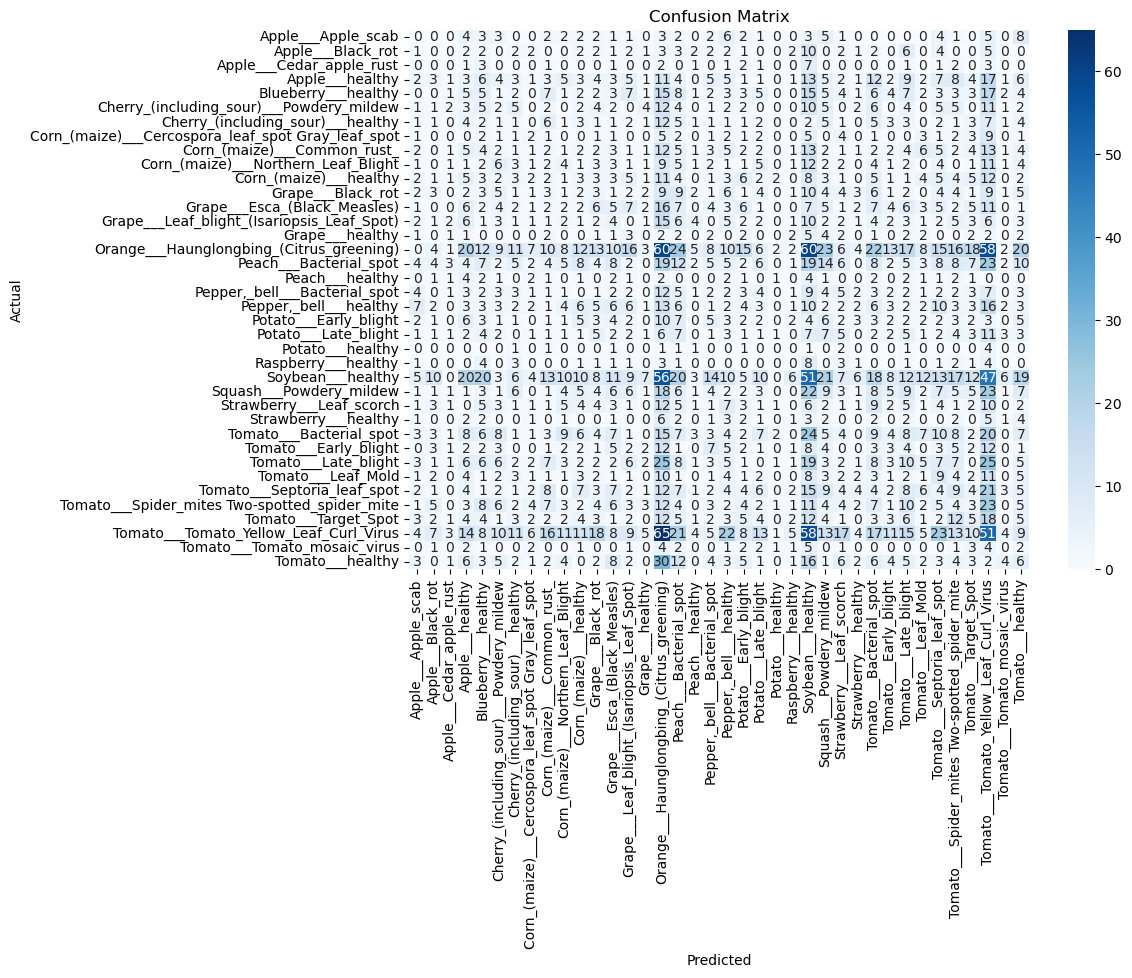

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.00      0.00      0.00        63
                                 Apple___Black_rot       0.00      0.00      0.00        62
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        27
                                   Apple___healthy       0.02      0.02      0.02       164
                               Blueberry___healthy       0.03      0.03      0.03       150
          Cherry_(including_sour)___Powdery_mildew       0.02      0.02      0.02       105
                 Cherry_(including_sour)___healthy       0.01      0.01      0.01        85
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.04      0.04      0.04        52
                       Corn_(maize)___Common_rust_       0.02      0.02      0.02       119
               Corn_(maize)___Northern_Leaf_Blight       0.04      0.04      0.

In [286]:
# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

### Test Loss vs. Accuracy Trend
- Test loss should decrease and remain lower, while accuracy increases after training.
- If the test loss starts increasing while accuracy plateaus, this indicates overfitting.
- You can add regularization, dropout, or more augmentation if overfitting occurs

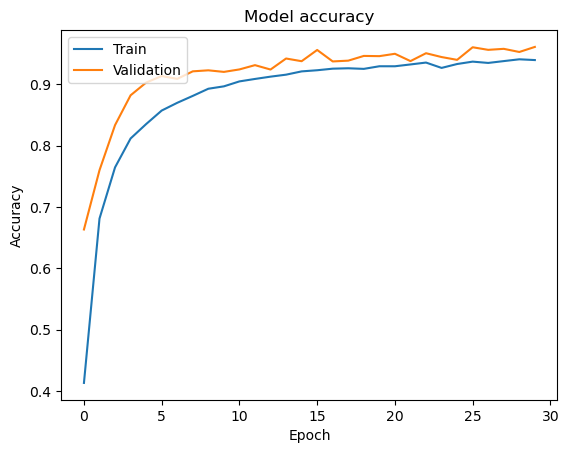

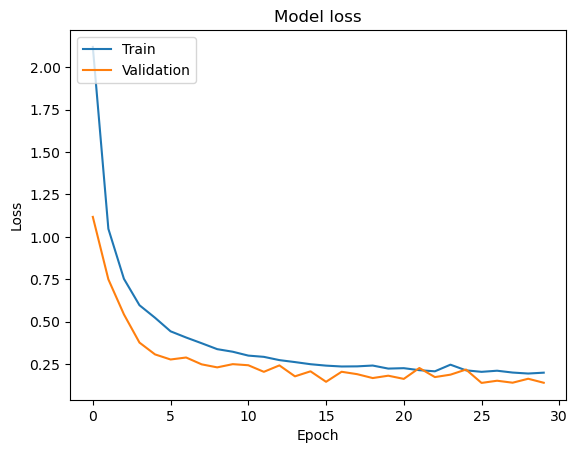

In [235]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Generalization on Unseen Data
- Model should correctly classify at least 80% of unseen images

In [298]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load an external image
# img_path = './data/test/Cherry_(including_sour)___healthy/014161fb-3c15-414b-9af3-00cb51a11d7c___JR_HL 9842.JPG'
img_path = './soybean.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict the class
pred_class = np.argmax(model.predict(img_array), axis=1)
print(f"Predicted class: {list(train_generator.class_indices.keys())[pred_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted class: Squash___Powdery_mildew


### Save Model

In [ ]:
# Save the trained model
model.save('plant_disease_cnn.keras')

In [ ]:
disease_metadata = {
    "Apple___Apple_scab": {
        "symptoms": "Olive-green or brown spots on leaves and fruits. The infected fruit may have corky scabs.",
        "cure": "Apply fungicides such as captan or sulfur. Prune trees to increase air circulation."
    },
    "Apple___Black_rot": {
        "symptoms": "Concentric brown rings on leaves and fruit. Fruit rots from the blossom end.",
        "cure": "Remove and destroy infected leaves and fruit. Apply copper-based fungicides."
    },
    "Apple___Cedar_apple_rust": {
        "symptoms": "Yellow-orange spots on leaves that eventually develop black spots in the center. Fruit lesions may also occur.",
        "cure": "Use resistant apple varieties. Apply fungicides like myclobutanil or mancozeb."
    },
    "Apple___healthy": {
        "symptoms": "No symptoms; the plant is healthy.",
        "cure": "No treatment needed for healthy plants."
    },
    "Blueberry___healthy": {
        "symptoms": "No symptoms; the plant is healthy.",
        "cure": "No treatment needed for healthy plants."
    },
    "Cherry_(including_sour)___Powdery_mildew": {
        "symptoms": "White, powdery fungal growth on leaves, stems, and fruit. Leaves may become twisted or stunted.",
        "cure": "Use sulfur-based fungicides. Prune infected branches and improve air circulation."
    },
    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot": {
        "symptoms": "Long, narrow gray or brown lesions on leaves. Severe infections cause leaf death.",
        "cure": "Rotate crops. Use resistant varieties and apply fungicides like azoxystrobin."
    },
    "Corn_(maize)___Common_rust_": {
        "symptoms": "Red to brown pustules on both leaf surfaces. Leaves may die prematurely if infection is severe.",
        "cure": "Apply fungicides such as mancozeb or propiconazole. Plant rust-resistant varieties."
    },
    "Corn_(maize)___Northern_Leaf_Blight": {
        "symptoms": "Long, elliptical gray-green lesions on leaves that eventually turn brown.",
        "cure": "Apply fungicides and ensure good crop rotation to minimize spread."
    },
    "Grape___Black_rot": {
        "symptoms": "Small, circular black spots on leaves. Berries rot and shrivel into black mummies.",
        "cure": "Remove infected fruit and leaves. Apply fungicides like captan or myclobutanil."
    },
    "Grape___healthy": {
        "symptoms": "No symptoms; the plant is healthy.",
        "cure": "No treatment needed for healthy plants."
    },
    "Orange___Haunglongbing_(Citrus_greening)": {
        "symptoms": "Yellowing of leaves, blotchy mottling, and misshapen fruits. Fruits taste bitter and are small.",
        "cure": "Remove and destroy infected trees. Use disease-free nursery stock. Control the Asian citrus psyllid with insecticides."
    },
    "Peach___Bacterial_spot": {
        "symptoms": "Small, dark spots on leaves, eventually leading to leaf drop. Fruit develops water-soaked spots.",
        "cure": "Apply copper-based sprays. Remove and destroy infected leaves and fruit."
    },
    "Potato___Early_blight": {
        "symptoms": "Brown spots with concentric rings on leaves, and dark, sunken spots on tubers.",
        "cure": "Use resistant varieties and apply fungicides like chlorothalonil. Practice crop rotation."
    },
    "Tomato___Spider_mites Two-spotted_spider_mite": {
        "symptoms": "Fine webbing on undersides of leaves, along with yellow or bronze-colored speckling.",
        "cure": "Apply insecticidal soap or horticultural oil. Increase humidity around plants."
    },
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus": {
        "symptoms": "Yellowing and upward curling of leaves. Plants become stunted with reduced fruit yield.",
        "cure": "Control whiteflies with insecticidal sprays. Use virus-resistant tomato varieties."
    },
    "Tomato___healthy": {
        "symptoms": "No symptoms; the plant is healthy.",
        "cure": "No treatment needed for healthy plants."
    }
}


In [ ]:
# Save the class indices for future reference
import json
class_indices = train_generator.class_indices

with open('class_indices.json', 'w') as f:
    json.dump(class_indices, f)
    
# Invert class indices to get class names from model output
class_labels = {v: k for k, v in class_indices.items()}

# Function to get disease details
def get_disease_details(predicted_class):
    if predicted_class in disease_metadata:
        return disease_metadata[predicted_class]
    else:
        return {"symptoms": "N/A", "cure": "N/A"}

In [ ]:
# Predict the disease from the image
Y_pred = model.predict(image_to_predict)  # `image_to_predict` is preprocessed input image
predicted_class_idx = np.argmax(Y_pred)
predicted_class = class_labels[predicted_class_idx]

# Get disease details (symptoms and cure)
disease_details = get_disease_details(predicted_class)

# Output the prediction, symptoms, and cure
print(f"Predicted Disease: {predicted_class}")
print(f"Symptoms: {disease_details['symptoms']}")
print(f"Cure: {disease_details['cure']}")
